# Forward Euler Evolution

In [1]:
from copy import deepcopy

import numpy as np
import scipy.signal as signal

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
sns.set_style("ticks")

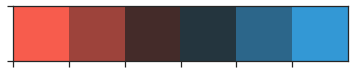

In [2]:
def define_palette():
    args = (15, 240)
    kwargs = dict(s=90, l=60, center="dark")
    p = sns.diverging_palette(*args, **kwargs)
    c = sns.diverging_palette(*args, **kwargs, as_cmap=True)
    
    return p, c

palette, colormap = define_palette()
sns.set_palette(palette)
sns.palplot(palette)

## Evolution step

Definition for alternative evolution steps:
- advection
    - `fee`: forward Euler evolution
    - `lax`: lax method
- diffusion
    - `diffusion`: forward solution

In [3]:
def fee(rho_t, alpha):
    rho_t1 = deepcopy(rho_t)
    
    rho_t1 -= ((alpha / 2) * (np.roll(rho_t, 1) - np.roll(rho_t, -1)))
    
    return rho_t1

# Test it
a = np.arange(10, dtype=np.float64)
np.vstack([a, fee(a, 1)])

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [-4.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,  5.]])

In [4]:
def lax(rho_t, alpha):
    rho_t1 = deepcopy(rho_t)
    
    rho_t1 = ((1 / 2) * (np.roll(rho_t, 1) + np.roll(rho_t, -1))) + ((alpha / 2) * (np.roll(rho_t, 1) - np.roll(rho_t, -1)))
    
    return rho_t1

# Test it
a = np.arange(10, dtype=np.float64)
np.vstack([a, lax(a, 1)])

array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [9., 0., 1., 2., 3., 4., 5., 6., 7., 8.]])

In [5]:
def diffusion(rho_t, alpha):
    rho_t1 = deepcopy(rho_t)
    
    rho_t1 += 2 * alpha * (np.roll(rho_t, 1) + np.roll(rho_t, -1) - 2 * rho_t)
    
    return rho_t1

# Test it
a = np.zeros(10, dtype=np.float64)
a[5] = 1
np.vstack([a, diffusion(a, 1)])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  2., -3.,  2.,  0.,  0.,  0.]])

## Initial conditions

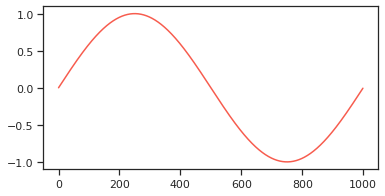

In [6]:
def ic_sin(shift, k, n_x):
    return np.array([np.sin(k*(i/n_x - shift)*np.pi)  for i in range(n_x)])

plt.figure(figsize=(6,3))
n_x = 1000
plt.plot(np.arange(n_x), ic_sin(0, 2, n_x))
plt.show()

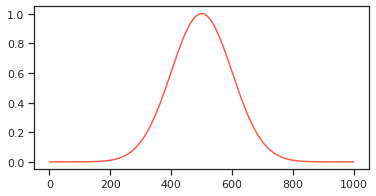

In [7]:
def ic_gauss(μ, σ, n_x):
    return np.array([np.exp(-((i - μ)/n_x)**2 / (2*(σ/n_x)**2))  for i in range(n_x)])

plt.figure(figsize=(6,3))
n_x = 1000
plt.plot(np.arange(n_x), ic_gauss(n_x/2, 100, n_x))
plt.show()

## BC

### PBC

In [8]:
def pbc(theory, setup, evolution_step=lambda x, *args: x):
    alpha = theory['alpha'];
    
    n_t = setup['n_t']
    n_x = setup['n_x']

    rho_t0 = setup['ic']
    
    rho_tm = deepcopy(rho_t0)
    rho = rho_tm

    for i in range(n_t):
        # evolve
        rho_tm1 = evolution_step(rho_tm, alpha)

        # update current
        rho_tm = deepcopy(rho_tm1)

        rho = np.vstack([rho, rho_tm1])

    return rho.T

### Open/Closed BC
From ZeroBC (open) to Mass conservation (closed).

In [9]:
def ocbc(theory, setup, bc=(1, 1), evolution_step=lambda x, *args: x):
    """
        Parameters
        ----------
        theory : dict
            theory configurations (alpha)
        setup : dict
            setup configurations (space grid, evolution steps, initial conditions)
        bc : tuple
            2-elements tuple to specify `boundary conditions`. The first element 
            set the condition on the left border, the second on the right one.
            When a border is set to 1 open border condition is applied, when 0 
            the closed one instead. Intermediate value are available.
    """
    for bc_coeff in bc:
        if bc_coeff < 0 or bc_coeff > 1:
            raise ValueError("Only boundary conditions for open, closed or"
                             "intermediate boundary are available [0 < bc < 1]")
    
    alpha = theory['alpha'];
    
    n_t = setup['n_t']
    n_x = setup['n_x']

    rho_t0 = setup['ic']
    
    rho_tm = deepcopy(rho_t0)
    rho = rho_tm
    
    for i in range(n_t):
        # evolve
        rho_tm1 = evolution_step(rho_tm, alpha)

        # impose BC
        rho_tm1[0] = (1 - bc[0]) * rho_tm1[1]
        rho_tm1[1] = (1 - bc[1]) * rho_tm1[-2]

        # update current
        rho_tm = deepcopy(rho_tm1)

        rho = np.vstack([rho, rho_tm1])

    return rho.T

## Analysis

In [10]:
def windowed_evolution(rho, window):
    n_x, n_t = rho_pbc_fee.shape

    # Plot evolution

    plt.figure(figsize=(20,10))

    rho_plot = deepcopy(rho)
    rho_plot[slice(*window[0]), slice(*window[1])] = 0

    ax_ev = sns.heatmap(rho,
                        xticklabels=(n_t // 10),
                        yticklabels=(n_x // 10),
                        cmap=colormap,
                        mask=(rho_plot==0),
                     )
    ax_ev.invert_yaxis()

    # Plot window

    plt.figure(figsize=(20,10))

    rho_window = rho[slice(*window[0]), slice(*window[1])]
    ax_wind = sns.heatmap(rho_window,
                     xticklabels=((window[1][1] - window[1][0]) // 10),
                     yticklabels=((window[0][1] - window[0][0]) // 10),
                     cmap=colormap)
    ax_wind.invert_yaxis()

### PBC FEE

In [11]:
theory_pbc_fee = dict(alpha=0.5)

n_t = 330
n_x = 1000
setup_pbc_fee = dict(
    n_t=n_t,
    n_x=n_x,
    ic=ic_sin(0., 2, n_x)
)

# run
rho_pbc_fee = pbc(theory_pbc_fee, setup_pbc_fee, evolution_step=fee)

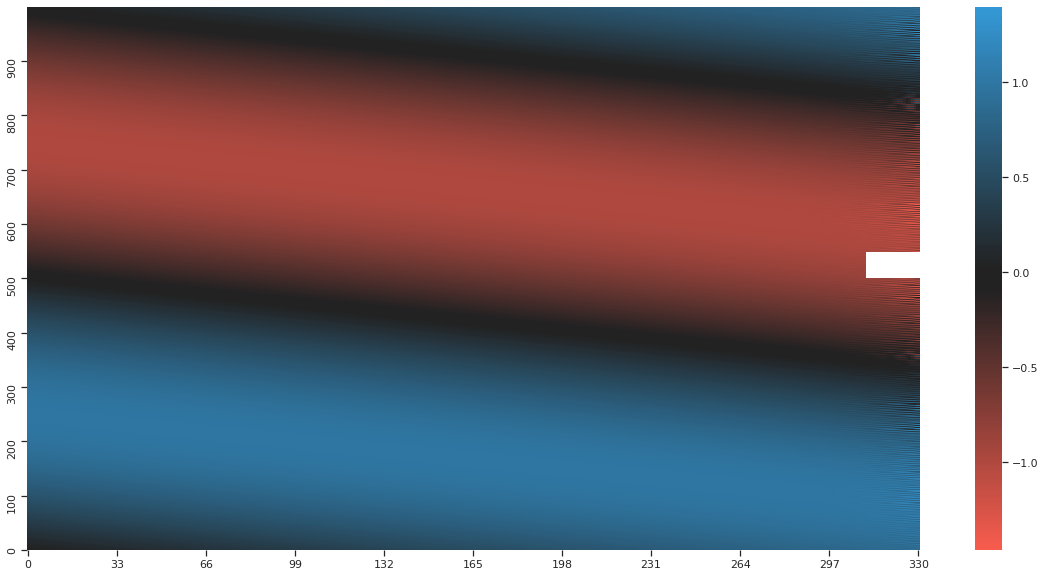

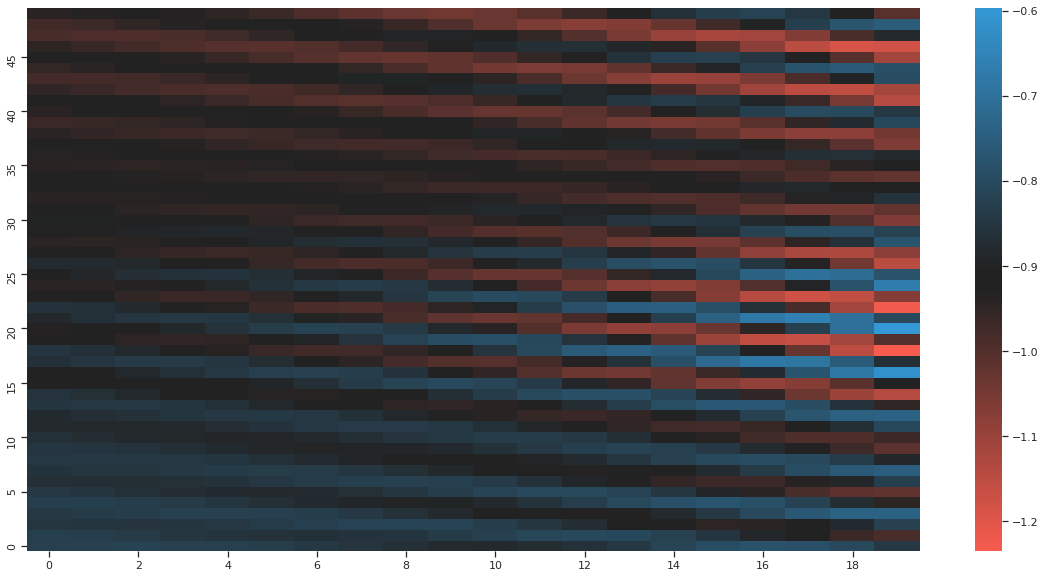

In [12]:
n_x, n_t = rho_pbc_fee.shape
window = (n_x // 2, n_x // 2 + 50), (n_t - 20, n_t)

windowed_evolution(rho_pbc_fee, window)

### PBC Lax

In [13]:
theory_pbc_lax = dict(alpha=0.5)

n_t = 1000
n_x = 1000
setup_pbc_lax = dict(
    n_t=n_t,
    n_x=n_x,
    ic=ic_sin(0., 2, n_x)
)

# run
rho_pbc_lax = pbc(theory_pbc_lax, setup_pbc_lax, evolution_step=lax)

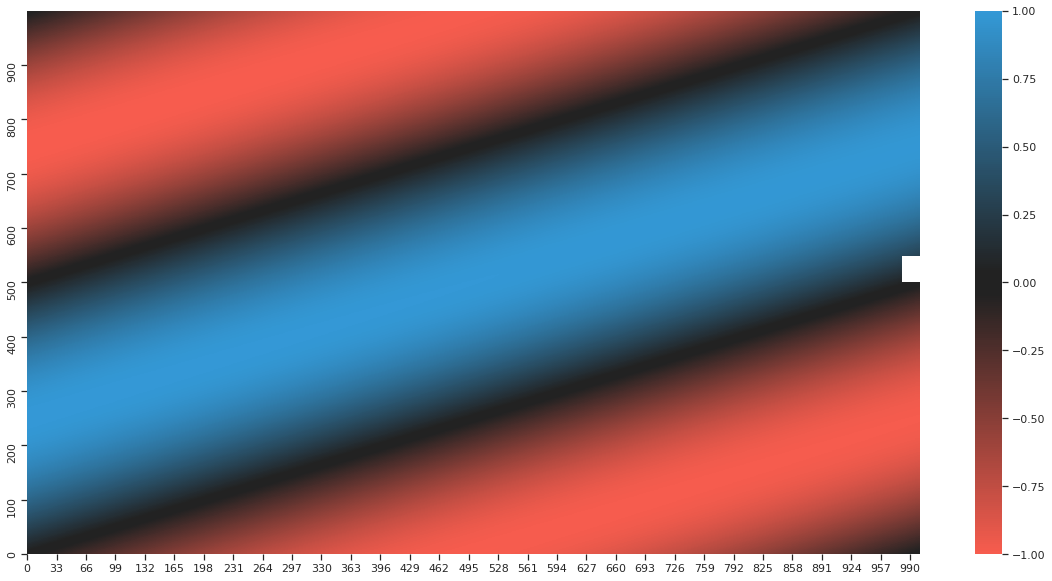

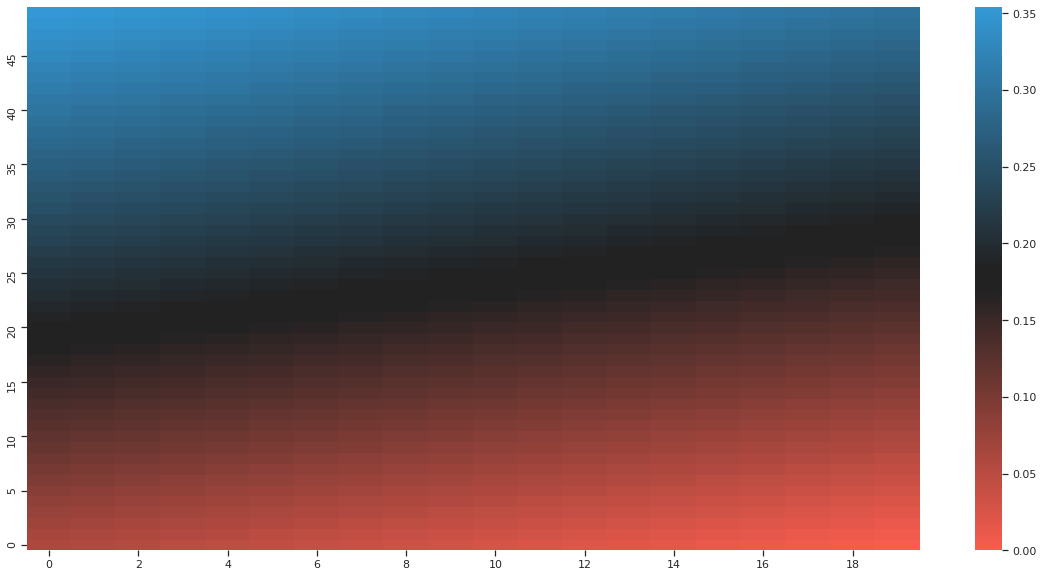

In [14]:
n_x, n_t = rho_pbc_lax.shape
window = (n_x // 2, n_x // 2 + 50), (n_t - 20, n_t)

windowed_evolution(rho_pbc_lax, window)

 ### PBC diffusion

In [15]:
theory_pbc_diff = dict(alpha=0.2)

n_t = 1000
n_x = 1000
setup_pbc_diff = dict(
    n_t=n_t,
    n_x=n_x,
    ic=ic_gauss(n_x / 2, n_x / 10, n_x)
)

# run
rho_pbc_diff = pbc(theory_pbc_diff, setup_pbc_diff, evolution_step=diffusion)

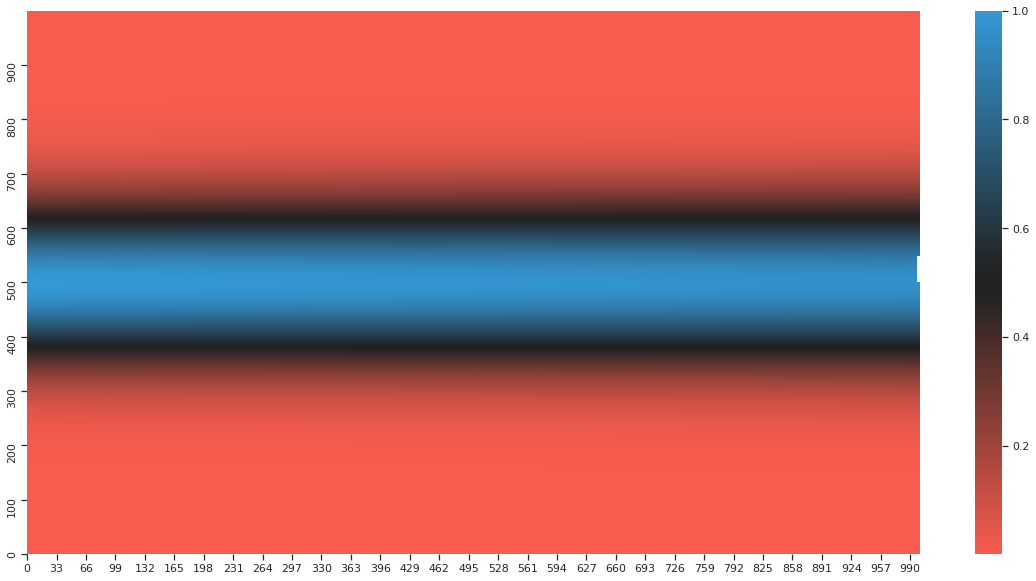

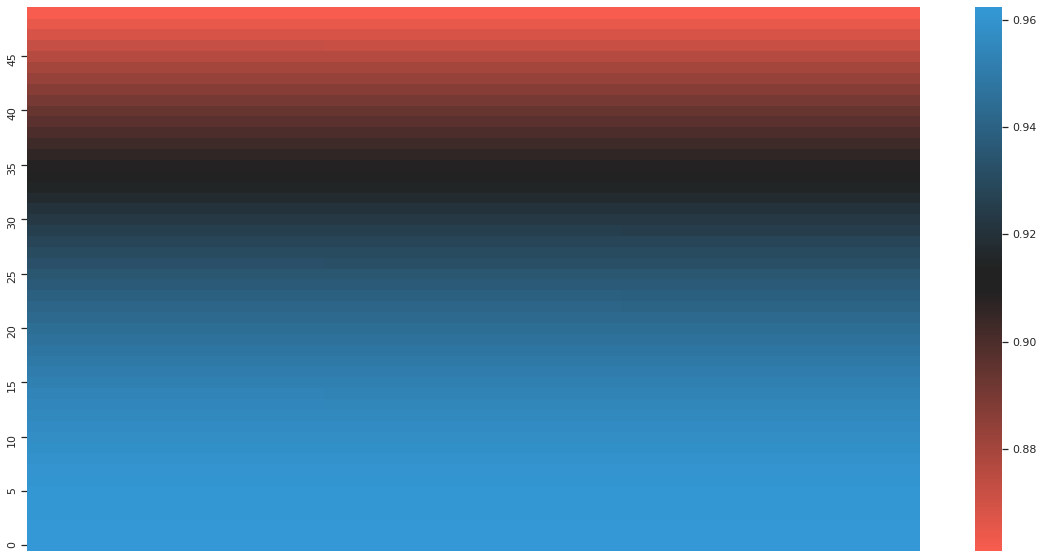

In [16]:
n_x, n_t = rho_pbc_diff.shape
window = (n_x // 2, n_x // 2 + 50), (n_t - 3, n_t)

windowed_evolution(rho_pbc_diff, window)

## Open BC

In [17]:
theory_pbc_lax = dict(alpha=0.5)

n_t = 1000
n_x = 1000
setup_pbc_lax = dict(
    n_t=n_t,
    n_x=n_x,
    ic=ic_sin(0., 2, n_x)
)

# run
rho_pbc_lax_open = ocbc(theory_pbc_lax, setup_pbc_lax, evolution_step=lax)

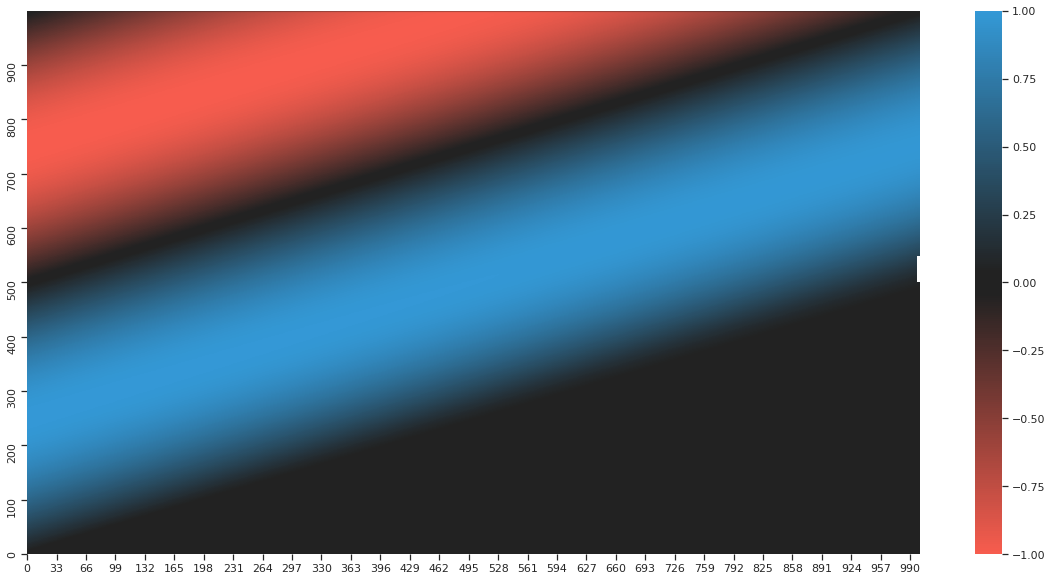

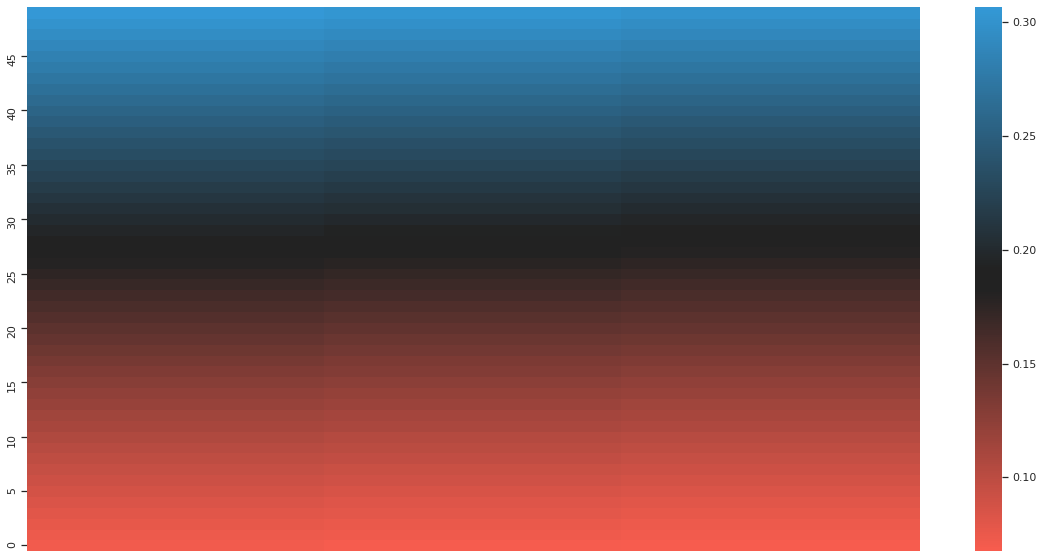

In [18]:
n_x, n_t = rho_pbc_lax_open.shape
window = (n_x // 2, n_x // 2 + 50), (n_t - 3, n_t)

windowed_evolution(rho_pbc_lax_open, window)

## Closed BC

In [19]:
theory_pbc_lax = dict(alpha=0.5)

n_t = 1000
n_x = 1000
setup_pbc_lax = dict(
    n_t=n_t,
    n_x=n_x,
    ic=ic_sin(0., 2, n_x)
)

# run
rho_pbc_lax_closed = ocbc(theory_pbc_lax, setup_pbc_lax, bc=(0,0), evolution_step=lax)

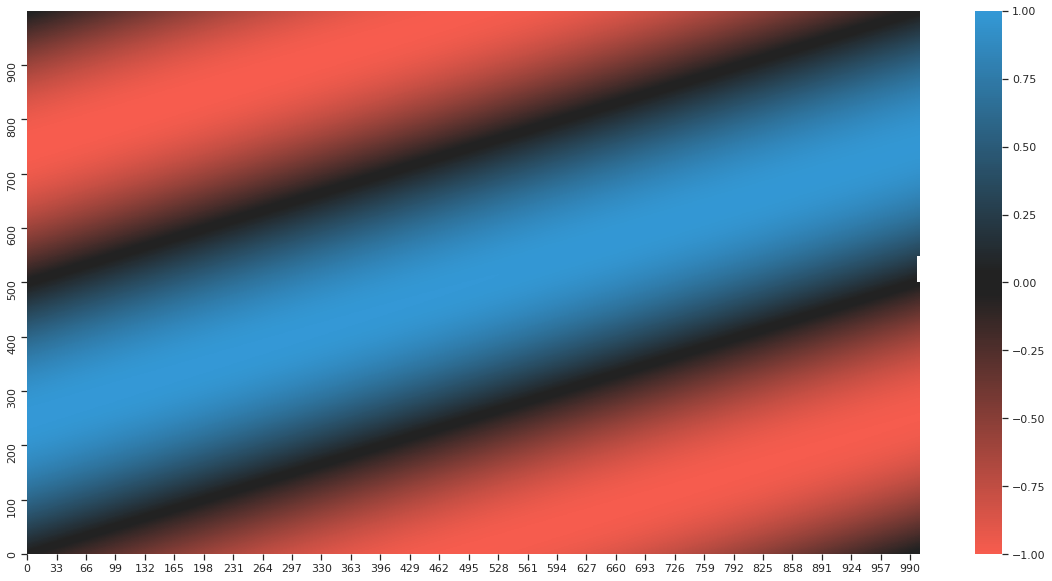

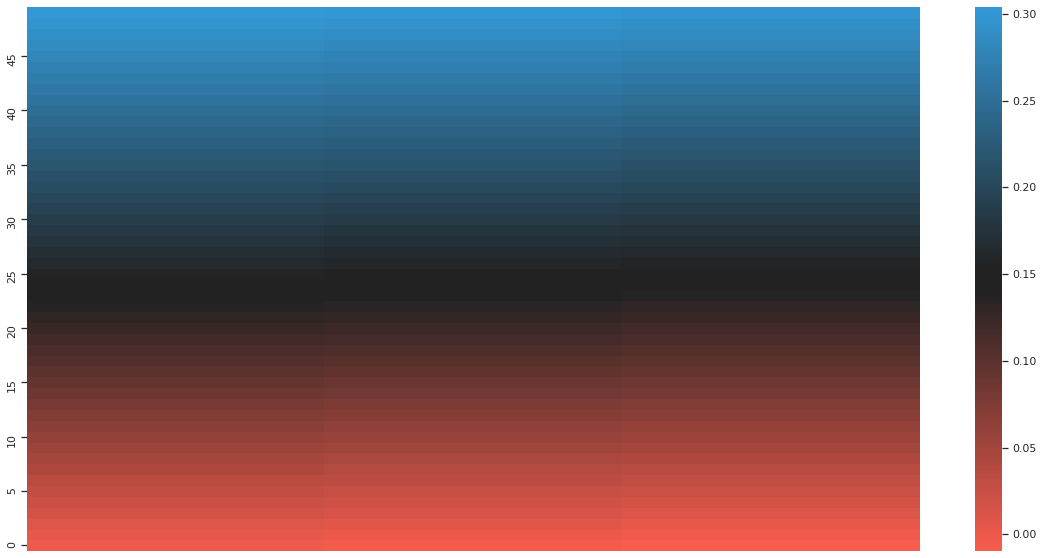

In [20]:
n_x, n_t = rho_pbc_lax_closed.shape
window = (n_x // 2, n_x // 2 + 50), (n_t - 3, n_t)

windowed_evolution(rho_pbc_lax_closed, window)